# Privacy–Utility Trade-off for Code Completion (HumanEval)

### Imports

In [ ]:
# If running on Colab:
# !pip install -r ../requirements.txt

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

import sys
from pathlib import Path

# Add project root to PYTHONPATH
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

from src.utils import low_obfuscation, high_obfuscation, privacy_score, utility_score_rougeL

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


/Volumes/T7 Shiled/projects(repos)/Privacy-Preserving-LLM-Code-Complition/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Utils

In [6]:
from __future__ import annotations

import ast
import builtins
import io
import keyword
import re
import tokenize
from typing import Dict, Set

from rouge_score import rouge_scorer
from rapidfuzz.distance import Levenshtein

_PY_KEYWORDS: Set[str] = set(keyword.kwlist)
_BUILTINS: Set[str] = set(dir(builtins))


# Helpers

def _strip_comments(code: str) -> str:
    """Remove # comments, keep everything else."""
    out_tokens = []
    try:
        tokgen = tokenize.generate_tokens(io.StringIO(code).readline)
        for tok_type, tok_str, *_ in tokgen:
            if tok_type != tokenize.COMMENT:
                out_tokens.append((tok_type, tok_str))
        return tokenize.untokenize(out_tokens)
    except Exception:
        return re.sub(r"#.*", "", code)


def _normalize_docstring(ds: str) -> str:
    """
    Keep only the first sentence of a docstring.
    Removes examples, lists, and extra detail.
    """
    ds = ds.strip()
    # Cut at first example or doctest
    ds = ds.split(">>>")[0]
    # Take first sentence
    match = re.split(r"\.\s+", ds, maxsplit=1)
    return match[0].strip() + "." if match else ds


def _collect_body_names(func: ast.FunctionDef) -> Set[str]:
    """Collect identifiers used inside function body only."""
    names: Set[str] = set()

    class Visitor(ast.NodeVisitor):
        def visit_Name(self, node: ast.Name):
            names.add(node.id)

        def visit_Attribute(self, node: ast.Attribute):
            self.visit(node.value)

    for stmt in func.body:
        Visitor().visit(stmt)

    return names


def _make_name_mapping(used_names: Set[str], mode: str) -> Dict[str, str]:
    mapping: Dict[str, str] = {}
    i = 0

    for name in sorted(used_names):
        if (
            name in _PY_KEYWORDS
            or name in _BUILTINS
            or name.startswith("__")
            or name in {"self", "cls"}
        ):
            continue

        new_name = f"v{i}" if mode == "low" else f"VAR_{i}"
        while new_name in used_names:
            i += 1
            new_name = f"v{i}" if mode == "low" else f"VAR_{i}"

        mapping[name] = new_name
        i += 1

    return mapping


# AST transformers

class _Renamer(ast.NodeTransformer):
    def __init__(self, mapping: Dict[str, str]):
        self.mapping = mapping

    def visit_Name(self, node: ast.Name):
        if node.id in self.mapping:
            return ast.copy_location(
                ast.Name(id=self.mapping[node.id], ctx=node.ctx), node
            )
        return node

    def visit_Attribute(self, node: ast.Attribute):
        node.value = self.visit(node.value)
        return node

    def visit_FunctionDef(self, node: ast.FunctionDef):
        # Preserve API: name, args, returns, decorators
        node.body = [self.visit(stmt) for stmt in node.body]
        return node


class _LiteralMasker(ast.NodeTransformer):
    """Mask string and numeric literals."""

    def visit_Constant(self, node: ast.Constant):
        if isinstance(node.value, str):
            return ast.copy_location(ast.Constant(value="STR"), node)
        if isinstance(node.value, (int, float)):
            return ast.copy_location(ast.Constant(value=0), node)
        return node


class _DocstringNormalizer(ast.NodeTransformer):
    def visit_FunctionDef(self, node: ast.FunctionDef):
        if (
            node.body
            and isinstance(node.body[0], ast.Expr)
            and isinstance(node.body[0].value, ast.Constant)
            and isinstance(node.body[0].value.value, str)
        ):
            node.body[0].value.value = _normalize_docstring(
                node.body[0].value.value
            )
        return node



# Public API

def low_obfuscation(prompt: str) -> str:
    """
    Low obfuscation:
    - rename local variables only
    - preserve signature, types, docstring
    - normalize formatting via AST
    """
    try:
        tree = ast.parse(prompt)
        for node in tree.body:
            if isinstance(node, ast.FunctionDef):
                names = _collect_body_names(node)
                mapping = _make_name_mapping(names, mode="low")
                _Renamer(mapping).visit(node)
        ast.fix_missing_locations(tree)
        return ast.unparse(tree)
    except Exception:
        return prompt


def high_obfuscation(prompt: str) -> str:
    """
    High obfuscation:
    - strip # comments
    - normalize docstring
    - rename locals aggressively
    - mask string & numeric literals
    """
    try:
        stripped = _strip_comments(prompt)
        tree = ast.parse(stripped)

        _DocstringNormalizer().visit(tree)
        _LiteralMasker().visit(tree)

        for node in tree.body:
            if isinstance(node, ast.FunctionDef):
                names = _collect_body_names(node)
                mapping = _make_name_mapping(names, mode="high")
                _Renamer(mapping).visit(node)

        ast.fix_missing_locations(tree)
        return ast.unparse(tree)
    except Exception:
        return prompt


# Metrics

def privacy_score(prompt_variant: str, prompt_original: str) -> float:
    if not prompt_original:
        return 0.0
    dist = Levenshtein.distance(prompt_variant, prompt_original)
    return dist / max(len(prompt_original), len(prompt_variant), 1)


_scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=False)

def utility_score_rougeL(completion: str, canonical_solution: str) -> float:
    scores = _scorer.score(canonical_solution, completion)
    return float(scores["rougeL"].fmeasure)


### Dataset Loading

In [2]:
# 1) Load dataset (first 20 examples from test split)

ds = load_dataset("openai/openai_humaneval", split="test")
ds20 = ds.select(range(20))

# Quick peek
ds20[0].keys(), ds20[0]["task_id"]


(dict_keys(['task_id', 'prompt', 'canonical_solution', 'test', 'entry_point']),
 'HumanEval/0')

In [3]:
# 2) Prepare prompt variants

rows = []
for ex in ds20:
    original = ex["prompt"]
    low = low_obfuscation(original)
    high = high_obfuscation(original)
    rows.append({
        "task_id": ex["task_id"],
        "prompt_original": original,
        "prompt_low": low,
        "prompt_high": high,
        "canonical_solution": ex["canonical_solution"],
    })

df = pd.DataFrame(rows)
df.head()


,task_id,prompt_original,prompt_low,prompt_high,canonical_solution
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,from typing import List\n\ndef has_close_eleme...,from typing import List\n\ndef has_close_eleme...,"for idx, elem in enumerate(numbers):\n ..."
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,from typing import List\n\ndef separate_paren_...,from typing import List\n\ndef separate_paren_...,result = []\n current_string = []\n ...
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,def truncate_number(number: float) -> float:\n...,def truncate_number(number: float) -> float:\n...,return number % 1.0\n
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,from typing import List\n\ndef below_zero(oper...,from typing import List\n\ndef below_zero(oper...,balance = 0\n\n for op in operations:\n...
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,from typing import List\n\ndef mean_absolute_d...,from typing import List\n\ndef mean_absolute_d...,mean = sum(numbers) / len(numbers)\n re...


### Model Loadning

In [4]:
# 3) Load model (default: CodeT5-small)

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

model_name = os.environ.get("MODEL_NAME", "Salesforce/codegen-350M-multi")

tok = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

device, model_name


Some weights of the model checkpoint at Salesforce/codegen-350M-multi were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on another task or with another architecture (

('mps', 'Salesforce/codegen-350M-multi')

In [5]:
def generate_completion(prompt: str,
                        max_new_tokens: int = 500,
                        temperature: float = 0.8,
                        top_p: float = 0.95) -> str:
    """Single sampled completion."""
    inputs = tok(
        prompt,
        return_tensors="pt",
        padding=False,
        truncation=True
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        out = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            eos_token_id=tok.eos_token_id,
            pad_token_id=tok.eos_token_id,  # important
        )
    text = tok.decode(out[0], skip_special_tokens=True)
    return text

# Sanity check (first example, original prompt)
print(df.loc[0, "task_id"])
print("____COMPLITION____")
print(generate_completion(df.loc[0, "prompt_original"])[:500])
print("____SOL____")
print(df.loc[0, "canonical_solution"][:500])


HumanEval/0
____COMPLITION____
from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """
    if len(numbers) < 2:
        return False
    return (numbers[0] > numbers[1] and numbers[0] > numbers[2] and numbers[1] > numbers[2])


def _sort_b
____SOL____
    for idx, elem in enumerate(numbers):
        for idx2, elem2 in enumerate(numbers):
            if idx != idx2:
                distance = abs(elem - elem2)
                if distance < threshold:
                    return True

    return False



### Generation of Complitions

In [6]:
# 4) Generate 60 completions total

outputs = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    for condition, prompt_col in [("original", "prompt_original"),
                                  ("low", "prompt_low"),
                                  ("high", "prompt_high")]:
        prompt = row[prompt_col]
        comp = generate_completion(prompt)

        outputs.append({
            "task_id": row["task_id"],
            "condition": condition,
            "prompt_used": prompt,
            "prompt_original": row["prompt_original"],
            "canonical_solution": row["canonical_solution"],
            "completion": comp,
        })

out_df = pd.DataFrame(outputs)
out_df.head()


100%|██████████| 20/20 [35:37<00:00, 106.88s/it]


,task_id,condition,prompt_used,prompt_original,canonical_solution,completion
0,HumanEval/0,original,from typing import List\n\n\ndef has_close_ele...,from typing import List\n\n\ndef has_close_ele...,"for idx, elem in enumerate(numbers):\n ...",from typing import List\n\n\ndef has_close_ele...
1,HumanEval/0,low,from typing import List\n\ndef has_close_eleme...,from typing import List\n\n\ndef has_close_ele...,"for idx, elem in enumerate(numbers):\n ...",from typing import List\n\ndef has_close_eleme...
2,HumanEval/0,high,from typing import List\n\ndef has_close_eleme...,from typing import List\n\n\ndef has_close_ele...,"for idx, elem in enumerate(numbers):\n ...",from typing import List\n\ndef has_close_eleme...
3,HumanEval/1,original,from typing import List\n\n\ndef separate_pare...,from typing import List\n\n\ndef separate_pare...,result = []\n current_string = []\n ...,from typing import List\n\n\ndef separate_pare...
4,HumanEval/1,low,from typing import List\n\ndef separate_paren_...,from typing import List\n\n\ndef separate_pare...,result = []\n current_string = []\n ...,from typing import List\n\ndef separate_paren_...


In [7]:
print("-----Original Prompt-----")
print(out_df.loc[4, "prompt_original"])
print("-----Prompt Used-----")
print(out_df.loc[4, "prompt_used"])
print("-----Canonical Solution-----")
print(out_df.loc[4, "canonical_solution"])
print("-----Completion-----")
print(out_df.loc[4, "completion"])

-----Original Prompt-----
from typing import List


def separate_paren_groups(paren_string: str) -> List[str]:
    """ Input to this function is a string containing multiple groups of nested parentheses. Your goal is to
    separate those group into separate strings and return the list of those.
    Separate groups are balanced (each open brace is properly closed) and not nested within each other
    Ignore any spaces in the input string.
    >>> separate_paren_groups('( ) (( )) (( )( ))')
    ['()', '(())', '(()())']
    """

-----Prompt Used-----
from typing import List

def separate_paren_groups(paren_string: str) -> List[str]:
    """ Input to this function is a string containing multiple groups of nested parentheses. Your goal is to
    separate those group into separate strings and return the list of those.
    Separate groups are balanced (each open brace is properly closed) and not nested within each other
    Ignore any spaces in the input string.
    >>> separate_paren_groups

In [8]:
# 5) Score utility + privacy

out_df["privacy"] = out_df.apply(lambda r: privacy_score(r["prompt_used"], r["prompt_original"]), axis=1)
out_df["utility"] = out_df.apply(lambda r: utility_score_rougeL(r["completion"], r["canonical_solution"]), axis=1)

out_df.groupby("condition")[["privacy","utility"]].mean()


,privacy,utility
condition,,
high,0.750310,0.100447
low,0.008304,0.075734
original,0.000000,0.094698


### Analysis

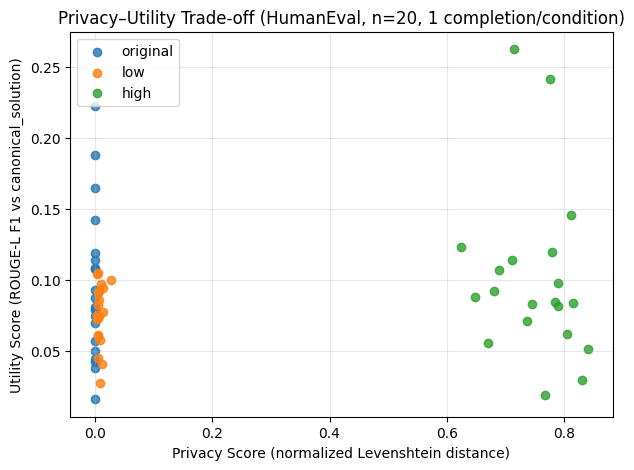

In [9]:
# 6) Scatter plot: Privacy vs Utility

plt.figure(figsize=(7,5))
for cond in ["original", "low", "high"]:
    sub = out_df[out_df["condition"] == cond]
    plt.scatter(sub["privacy"], sub["utility"], label=cond, alpha=0.8)

plt.xlabel("Privacy Score (normalized Levenshtein distance)")
plt.ylabel("Utility Score (ROUGE-L F1 vs canonical_solution)")
plt.title("Privacy–Utility Trade-off (HumanEval, n=20, 1 completion/condition)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Brief analysis (draft)

- **Expected trend**: as obfuscation increases, prompts diverge more from the original (privacy proxy ↑), but the model may lose signal and produce less overlapping text with the canonical solution (utility ↓).
- **Common failure mode**: lexical metrics (ROUGE) can drop even when the completion is functionally correct (e.g., different variable names or alternative implementations).
- **Interpretation caution**: normalized edit distance is not a formal privacy guarantee; it measures only text-level dissimilarity, not whether sensitive semantics can still be inferred.
